<a href="https://colab.research.google.com/github/rahuliyer/ai_experiments/blob/main/Leopard_or_Cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big cats classifier

This is a notebook to classify different types of big cats

## Install libraries

In [1]:
#hide
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

## Explore the data set

The data set is in the following structure
```
- big_cats/
    - train
        - african leopard/
        - caracal/
        - cheetah/
        ...
    - train
        - african leopard/
        - caracal/
        - cheetah/
        ...
    - test
        - african leopard/
        - caracal/
        - cheetah/
        ...
```

Clean images that do not load properly

In [3]:
from pathlib import Path

In [4]:
data_dir = Path('big_cats')

failed = verify_images(get_image_files(data_dir))
failed.map(Path.unlink)

(#0) []

## Training

In [5]:
def clear_gpu_cache():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

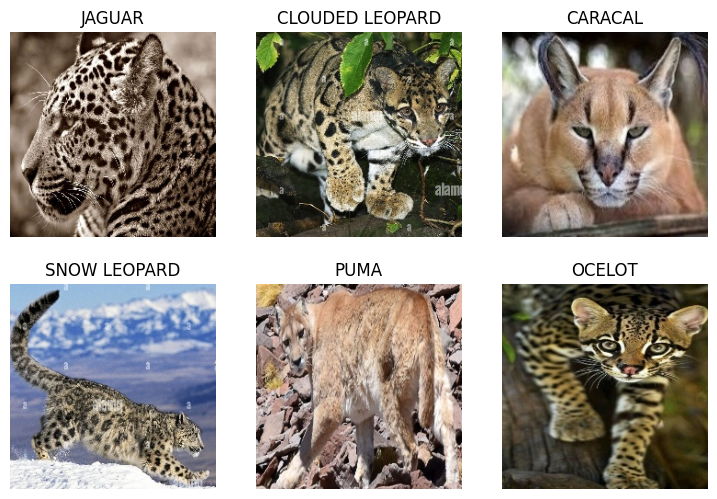

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name="train", valid_name="valid"),
    get_y=parent_label,
    item_tfms=[Resize(224, 224)],
).dataloaders(data_dir, bs=32)

dls.show_batch(max_n=6)

In [7]:
callbacks = [
    SaveModelCallback(monitor='valid_loss'),
    EarlyStoppingCallback(monitor='valid_loss', patience=5)
]

learn = vision_learner(dls, resnet101, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.131027,0.323210,0.140000,00:15


Better model found at epoch 0 with valid_loss value: 0.3232095241546631.


epoch,train_loss,valid_loss,error_rate,time
0,0.304370,0.091417,0.020000,00:21
1,0.175179,0.036562,0.000000,00:21
2,0.100303,0.038746,0.000000,00:21
3,0.068483,0.107966,0.040000,00:21
4,0.041075,0.076090,0.020000,00:21
5,0.055376,0.063035,0.040000,00:21
6,0.080173,0.257146,0.100000,00:21


Better model found at epoch 0 with valid_loss value: 0.09141673892736435.
Better model found at epoch 1 with valid_loss value: 0.03656237572431564.
No improvement since epoch 1: early stopping


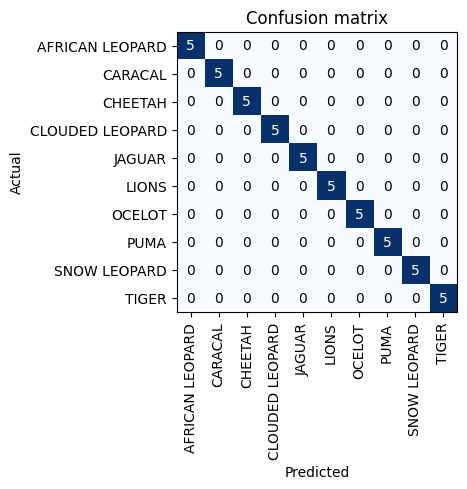

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

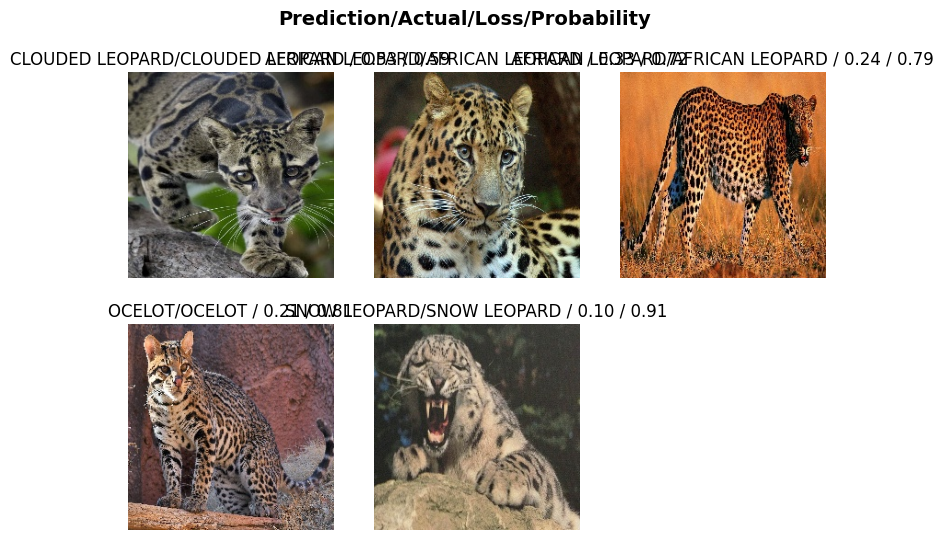

In [9]:
interp.plot_top_losses(5)

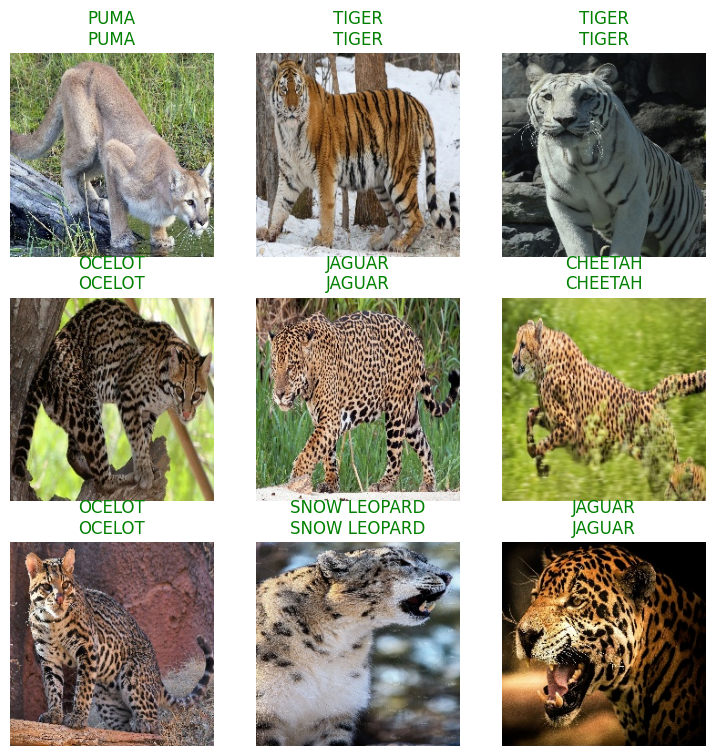

In [10]:
learn.show_results()

## Testing

In [11]:
test_files = get_image_files(data_dir/'test')

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def get_test_performance():
    label_indexes = {label: idx for idx, label in enumerate(learn.dls.vocab)}
    targets = torch.tensor([label_indexes[parent_label(f)] for f in test_files])
    test_dl = learn.dls.test_dl(test_files)
    preds = learn.get_preds(dl=test_dl, with_decoded=True)[2]

    cm = confusion_matrix(targets.tolist(), preds.tolist())
    acc = accuracy_score(targets.tolist(), preds.tolist())

    return (acc, cm)

In [13]:
acc, cm = get_test_performance()

In [14]:
acc

0.96

In [15]:
cm

array([[4, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])